In [4]:
# load data
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/users/zouyang/fer2013.csv")

In [8]:
# random select 1000 samples
# select 30000 * 0.01 = 300
# df2 = df.sample(frac=0.5)
df2 = df
df2 = df2.reset_index(drop=True)
df2.shape

(35887, 3)

In [9]:
%%time
df3 = df2.copy()
for i in range(len(df3.pixels)):
    df3.pixels[i] = np.array(list(map(int,df3.pixels[i].split(' '))))
    
X = np.array([i for i in df3.pixels])
y = np.array([i for i in df3.emotion])
n_samples, n_features = X.shape
names = np.array([i for i in df3.emotion])
# the shape of each picture
h = 48
w = 48
n_pictures = len(df3.pixels)
n_pixels = len(df3.pixels[0])

CPU times: user 10min 54s, sys: 1.61 s, total: 10min 55s
Wall time: 10min 55s


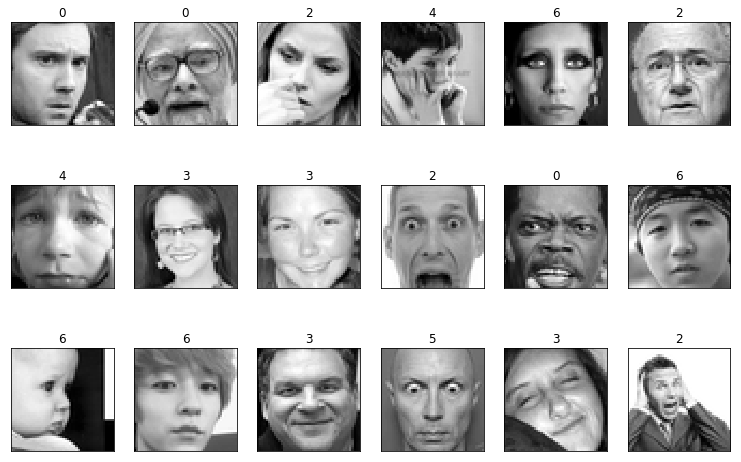

In [10]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(df3.pixels, df3.emotion, h, w, 3, 6)

# CNN parts

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

keras.__version__

Using TensorFlow backend.


'2.2.2'

In [13]:
X_train = df3['pixels'].values
y_train = df3['emotion'].values

X_train = np.concatenate(X_train)
X_train = np.expand_dims(X_train.reshape((len(df3['pixels']),48,48)), axis=3)
X_train.shape


(35887, 48, 48, 1)

In [14]:
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
classes = ['Angry', 'Disgust', 'Fear',
          'Happy', 'Sad','Surprise','Neutral']
img_wh = 48
NUM_CLASSES = len(classes)


In [15]:
from sklearn.model_selection import train_test_split

X = df3['pixels'].values
y = df3['emotion'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=20)
X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)

X_train = X_train/255.0 - 0.5
X_test = X_test/255.0 - 0.5

X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(X_train.shape)
print(X_test.shape)

(28709, 48, 48, 1)
(7178, 48, 48, 1)


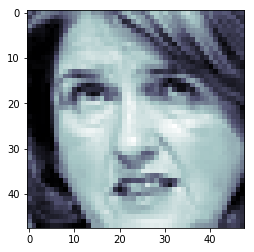

In [18]:
plt.imshow(X_train[1].squeeze(),cmap='bone')
plt.show()

# Modeling

[15 points] Create a convolutional neural network to use on your data using Keras. Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 

## LeNet

In [272]:
%%time

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.layers import average, concatenate
from keras.models import Input, Model

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=64, # change the number of filters
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

resnet.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 48, 48, 64)   640         input_16[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 24, 24, 64)   0           conv2d_45[0][0]                  
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 24, 24, 32)   18464       max_pooling2d_19[0][0]           
__________________________________________________________________________________________________
max_poolin

### Data expansion

Why the data expansion techinique is appropriate for my data?

We are using Face Expression Recognization dataset for this lab. Even for the same emotion of the same person like 'happy', he may perform different facial expressions according to how happy he is, that is, which level of happy he is in at that time. Besides, the face with expressions are more likely to be asymmetric and the head may be in a angle rather that vertical to the ground. Therefore, we use a data generator to generate faces that have slight rotation or symmetric of the original data.

In [273]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

# datagen.fit(X_train)

# idx = 0

In [274]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
# resnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
#                       steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
#                       epochs=50, verbose=1,
#                       validation_data=(X_test,y_test_ohe),
#                       callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
#                      )

# resnet.fit(X_train, y_train_ohe, batch_size=128, 
#                       epochs=50, verbose=1,
#                       validation_data=(X_test,y_test_ohe),
#                       callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
#                      )

# use data expansion
# resnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
#                    steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
#                    epochs=30, verbose=1,
#                    validation_data=(X_test,y_test_ohe)
#                   )

## Another CNN architecture

[20 points] Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).

## Xception

In [275]:
# Xception style architecture
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.layers import average, concatenate
from keras.models import Input, Model

l2_lambda = 0.000001



input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=64, # change the number of filters
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception_model = Model(inputs=input_holder,outputs=x)

xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 48, 48, 64)   640         input_17[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D) (None, 24, 24, 64)   0           conv2d_50[0][0]                  
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 24, 24, 32)   18464       max_pooling2d_22[0][0]           
__________________________________________________________________________________________________
max_poolin

In [276]:
# speed up by training by not using augmentation, perhaps there are faster ways??
# xception_model.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
#                 optimizer='adam', # 'adadelta' 'rmsprop'
#                 metrics=['accuracy'])

# xception_model.fit(X_train, y_train_ohe, batch_size=32,
#             epochs=50, verbose=1,
#             validation_data=(X_test,y_test_ohe),
#             callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
#             )

___

## Evaluation of Models

### Define a function of f1 calculation

In [277]:
# Since Keras removed f1_score at version 2.0.0, we use the calculation function from others
# Source: https://github.com/keras-team/keras/issues/5400, by Unnir

from keras import backend as K

def mcor(y_true, y_pred):
     #matthews_correlation
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
 
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
 
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
 
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
 
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
 
    return numerator / (denominator + K.epsilon())

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## Cross validation

Use Stratified K-fold to evaluate the general performance of two models.

In [278]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

### Xception performance

In [279]:
from matplotlib import pyplot as plt

n_folds = 10
skf = StratifiedKFold(n_splits=n_folds)

cv_training_f1_score = []
cv_training_loss = []

cv_val_f1_score = []
cv_val_loss = []

xception_model.compile(loss='binary_crossentropy',
              optimizer= "adam",
              metrics=[mcor,recall, f1])

iternum = 1
for train_indices, val_indices in skf.split(X_train, y_train):
    X_tmp_train = X_train[train_indices]
    y_tmp_train = y_train_ohe[train_indices]
    
    X_tmp_val = X_train[val_indices]
    y_tmp_val = y_train_ohe[val_indices]
    
    history = xception_model.fit_generator(datagen.flow(X_tmp_train, y_tmp_train, batch_size=32), 
                   steps_per_epoch=int(len(X_tmp_train)/32), # how many generators to go through per epoch
                   epochs=30, verbose=1,
                   validation_data=(X_tmp_val,y_tmp_val),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                  )
    # save the performance data of different training and validation set
    
    cv_training_f1_score.append(history.history.get('f1'))
    cv_val_f1_score.append(history.history.get('val_f1'))
    
    cv_training_loss.append(history.history.get('loss'))
    cv_val_loss.append(history.history.get('val_loss'))


Epoch 1/30
807/807 [==============================] - 17s 21ms/step - loss: 0.3772 - mcor: 0.0608 - recall: 0.0209 - f1: 0.0380 - val_loss: 0.3551 - val_mcor: 0.2480 - val_recall: 0.1186 - val_f1: 0.1994
Epoch 2/30
807/807 [==============================] - 12s 15ms/step - loss: 0.3546 - mcor: 0.1999 - recall: 0.0873 - f1: 0.1503 - val_loss: 0.3401 - val_mcor: 0.2634 - val_recall: 0.1384 - val_f1: 0.2268
Epoch 3/30
807/807 [==============================] - 12s 15ms/step - loss: 0.3389 - mcor: 0.2679 - recall: 0.1372 - f1: 0.2252 - val_loss: 0.3195 - val_mcor: 0.3461 - val_recall: 0.2250 - val_f1: 0.3364
Epoch 4/30
807/807 [==============================] - 12s 15ms/step - loss: 0.3268 - mcor: 0.3075 - recall: 0.1692 - f1: 0.2700 - val_loss: 0.3049 - val_mcor: 0.3693 - val_recall: 0.2355 - val_f1: 0.3522
Epoch 5/30
807/807 [==============================] - 12s 15ms/step - loss: 0.3182 - mcor: 0.3325 - recall: 0.1941 - f1: 0.3023 - val_loss: 0.2977 - val_mcor: 0.3863 - val_recall: 0.24

807/807 [==============================] - 12s 15ms/step - loss: 0.2747 - mcor: 0.4464 - recall: 0.3238 - f1: 0.4496 - val_loss: 0.2559 - val_mcor: 0.4696 - val_recall: 0.3468 - val_f1: 0.4732
Epoch 2/30
807/807 [==============================] - 12s 15ms/step - loss: 0.2755 - mcor: 0.4410 - recall: 0.3182 - f1: 0.4434 - val_loss: 0.2620 - val_mcor: 0.4557 - val_recall: 0.3503 - val_f1: 0.4688
Epoch 3/30
807/807 [==============================] - 12s 15ms/step - loss: 0.2766 - mcor: 0.4415 - recall: 0.3206 - f1: 0.4453 - val_loss: 0.2594 - val_mcor: 0.4571 - val_recall: 0.3405 - val_f1: 0.4631
Epoch 4/30
807/807 [==============================] - 11s 14ms/step - loss: 0.2724 - mcor: 0.4532 - recall: 0.3314 - f1: 0.4578 - val_loss: 0.2578 - val_mcor: 0.4685 - val_recall: 0.3440 - val_f1: 0.4709
Epoch 5/30
807/807 [==============================] - 12s 15ms/step - loss: 0.2737 - mcor: 0.4468 - recall: 0.3253 - f1: 0.4507 - val_loss: 0.2613 - val_mcor: 0.4687 - val_recall: 0.3471 - val_f1

### (Xception) Visualize the training and validation f1_score and loss of each iteration of every fold

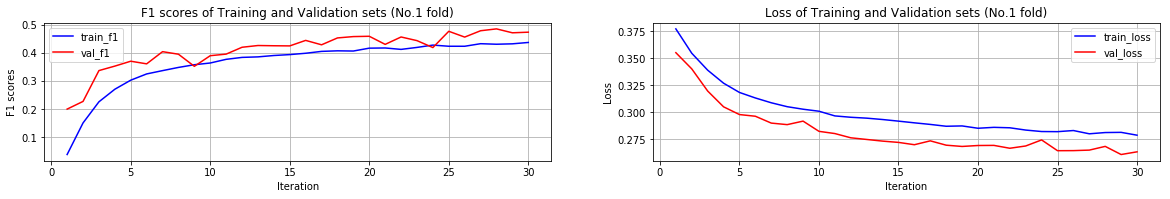

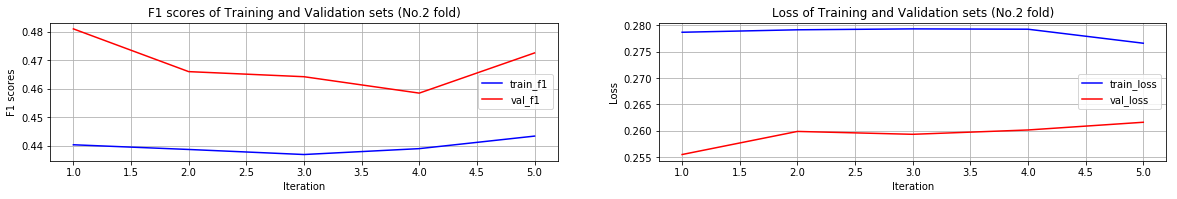

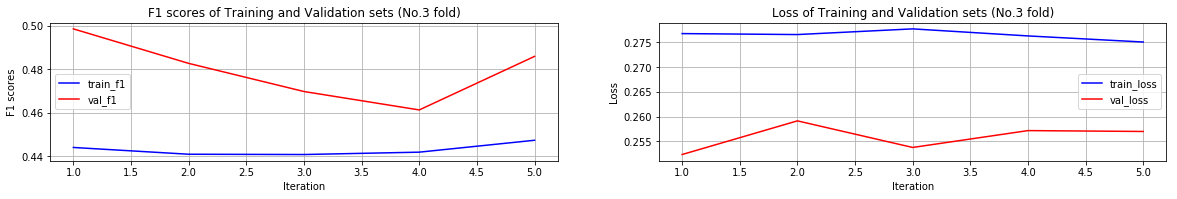

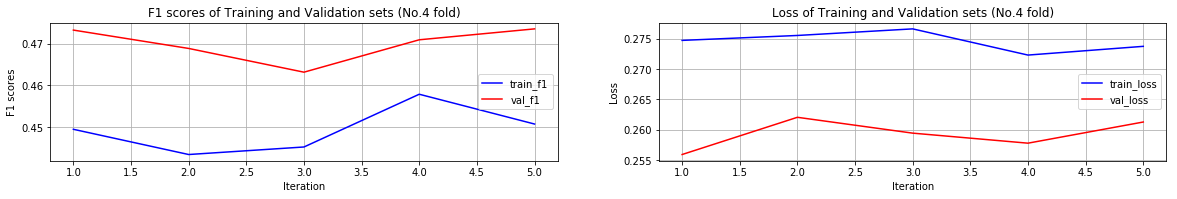

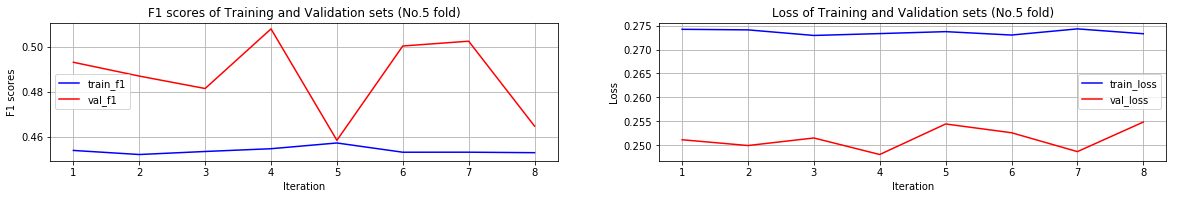

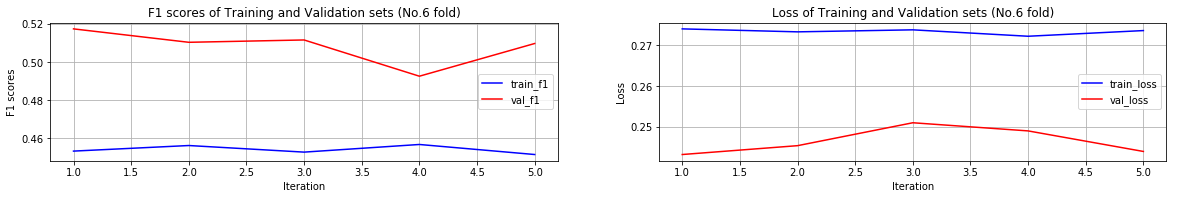

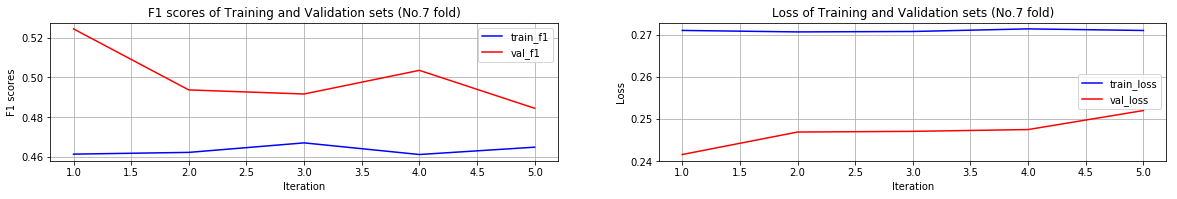

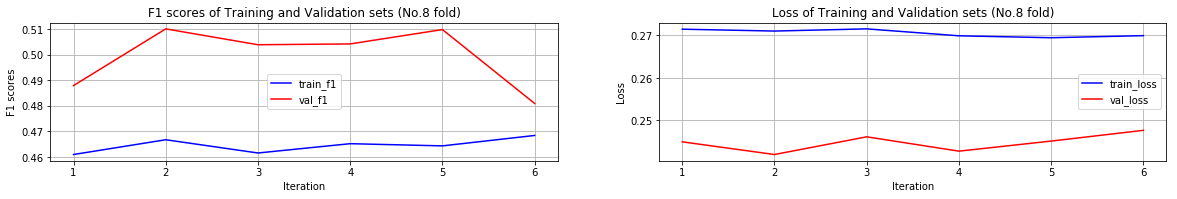

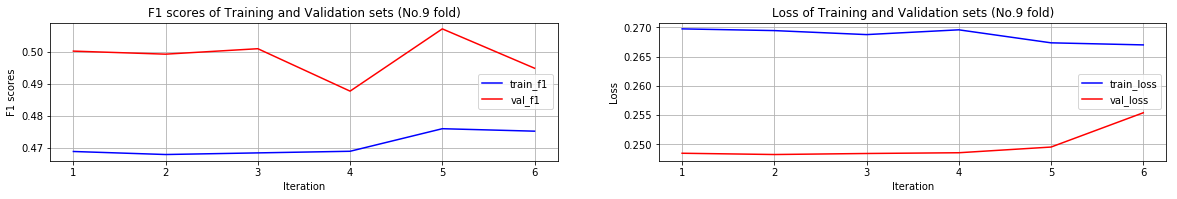

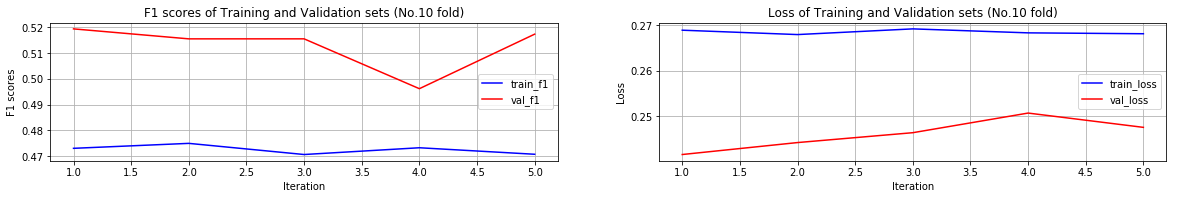

In [280]:
# there are 10 folds, so there are 10 groups of data
for i in range(0, len(cv_training_f1_score)):
    iteration = range(1,len(cv_training_f1_score[i])+1)
    plt.figure(figsize=(20,30))
    
    plt.subplot(10,2,1)
    plt.plot(iteration, cv_training_f1_score[i], linestyle='-', color='blue', label='train_f1')
    plt.plot(iteration, cv_val_f1_score[i], linestyle='-', color='red', label='val_f1')
    plt.grid()
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('F1 scores')
    plt.title('F1 scores of Training and Validation sets (No.%.0f fold)' % (i+1))
    
    plt.subplot(10,2,2)
    plt.plot(iteration, cv_training_loss[i], linestyle='-', color='blue', label='train_loss')
    plt.plot(iteration, cv_val_loss[i], linestyle='-', color='red', label='val_loss')
    plt.grid()
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss of Training and Validation sets (No.%.0f fold)' % (i+1))

### LeNet performance

In [281]:
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds)

cv_training_f1_score = []
cv_training_loss = []

cv_val_f1_score = []
cv_val_loss = []

resnet.compile(loss='binary_crossentropy',
              optimizer= "adam",
              metrics=[mcor,recall, f1])

for train_indices, val_indices in skf.split(X_train, y_train):
    X_tmp_train = X_train[train_indices]
    y_tmp_train = y_train_ohe[train_indices]
    
    X_tmp_val = X_train[val_indices]
    y_tmp_val = y_train_ohe[val_indices]
    
    history = resnet.fit_generator(datagen.flow(X_tmp_train, y_tmp_train, batch_size=128), 
                   steps_per_epoch=int(len(X_tmp_train)/128), # how many generators to go through per epoch
                   epochs=30, verbose=1,
                   validation_data=(X_tmp_val,y_tmp_val),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                  )
    
    cv_training_f1_score.append(history.history.get('f1'))
    cv_val_f1_score.append(history.history.get('val_f1'))
    
    cv_training_loss.append(history.history.get('loss'))
    cv_val_loss.append(history.history.get('val_loss'))


Epoch 1/30
201/201 [==============================] - 14s 72ms/step - loss: 0.3840 - mcor: 0.0374 - recall: 0.0105 - f1: 0.0197 - val_loss: 0.3578 - val_mcor: 0.1525 - val_recall: 0.0428 - val_f1: 0.0805
Epoch 2/30
201/201 [==============================] - 10s 49ms/step - loss: 0.3597 - mcor: 0.1889 - recall: 0.0760 - f1: 0.1346 - val_loss: 0.3402 - val_mcor: 0.2978 - val_recall: 0.1656 - val_f1: 0.2670
Epoch 3/30
201/201 [==============================] - 10s 49ms/step - loss: 0.3421 - mcor: 0.2719 - recall: 0.1315 - f1: 0.2213 - val_loss: 0.3198 - val_mcor: 0.3387 - val_recall: 0.2021 - val_f1: 0.3153
Epoch 4/30
201/201 [==============================] - 10s 48ms/step - loss: 0.3306 - mcor: 0.3093 - recall: 0.1654 - f1: 0.2684 - val_loss: 0.3150 - val_mcor: 0.3658 - val_recall: 0.2397 - val_f1: 0.3577
Epoch 5/30
201/201 [==============================] - 10s 49ms/step - loss: 0.3215 - mcor: 0.3325 - recall: 0.1888 - f1: 0.2996 - val_loss: 0.3003 - val_mcor: 0.3728 - val_recall: 0.23

201/201 [==============================] - 10s 49ms/step - loss: 0.2615 - mcor: 0.4828 - recall: 0.3662 - f1: 0.4950 - val_loss: 0.2472 - val_mcor: 0.5109 - val_recall: 0.3830 - val_f1: 0.5181
Epoch 7/30
201/201 [==============================] - 10s 48ms/step - loss: 0.2617 - mcor: 0.4772 - recall: 0.3634 - f1: 0.4907 - val_loss: 0.2457 - val_mcor: 0.5126 - val_recall: 0.3976 - val_f1: 0.5267
Epoch 8/30
201/201 [==============================] - 10s 48ms/step - loss: 0.2601 - mcor: 0.4847 - recall: 0.3698 - f1: 0.4980 - val_loss: 0.2453 - val_mcor: 0.5184 - val_recall: 0.4182 - val_f1: 0.5405
Epoch 9/30
201/201 [==============================] - 10s 48ms/step - loss: 0.2607 - mcor: 0.4856 - recall: 0.3700 - f1: 0.4983 - val_loss: 0.2464 - val_mcor: 0.5045 - val_recall: 0.3691 - val_f1: 0.5067
Epoch 1/30
201/201 [==============================] - 10s 48ms/step - loss: 0.2608 - mcor: 0.4848 - recall: 0.3688 - f1: 0.4974 - val_loss: 0.2422 - val_mcor: 0.5110 - val_recall: 0.3945 - val_f1

201/201 [==============================] - 10s 48ms/step - loss: 0.2497 - mcor: 0.5107 - recall: 0.4072 - f1: 0.5311 - val_loss: 0.2341 - val_mcor: 0.5207 - val_recall: 0.4172 - val_f1: 0.5409
Epoch 7/30
201/201 [==============================] - 10s 48ms/step - loss: 0.2488 - mcor: 0.5134 - recall: 0.4081 - f1: 0.5329 - val_loss: 0.2264 - val_mcor: 0.5540 - val_recall: 0.4353 - val_f1: 0.5673
Epoch 8/30
201/201 [==============================] - 10s 48ms/step - loss: 0.2484 - mcor: 0.5202 - recall: 0.4155 - f1: 0.5403 - val_loss: 0.2298 - val_mcor: 0.5432 - val_recall: 0.4263 - val_f1: 0.5569
Epoch 9/30
201/201 [==============================] - 10s 49ms/step - loss: 0.2484 - mcor: 0.5164 - recall: 0.4137 - f1: 0.5373 - val_loss: 0.2317 - val_mcor: 0.5455 - val_recall: 0.4259 - val_f1: 0.5583
Epoch 1/30
201/201 [==============================] - 10s 49ms/step - loss: 0.2482 - mcor: 0.5120 - recall: 0.4072 - f1: 0.5317 - val_loss: 0.2252 - val_mcor: 0.5589 - val_recall: 0.4406 - val_f1

### (LeNet) Visualize the training and validation f1_score and loss of each iteration of every fold

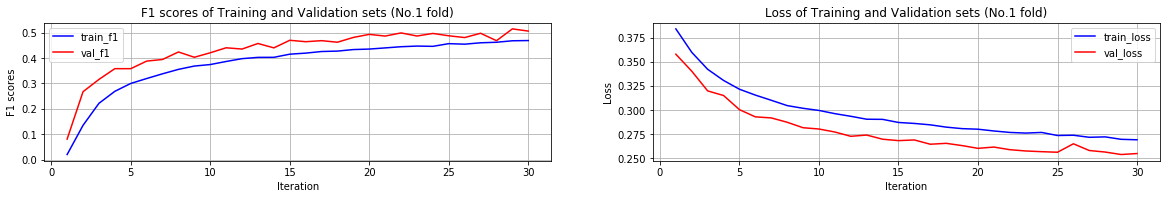

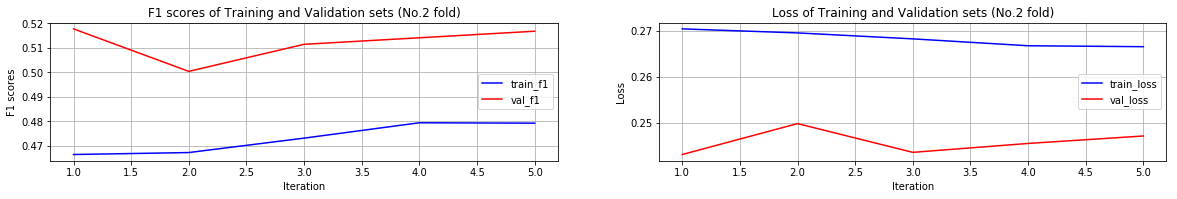

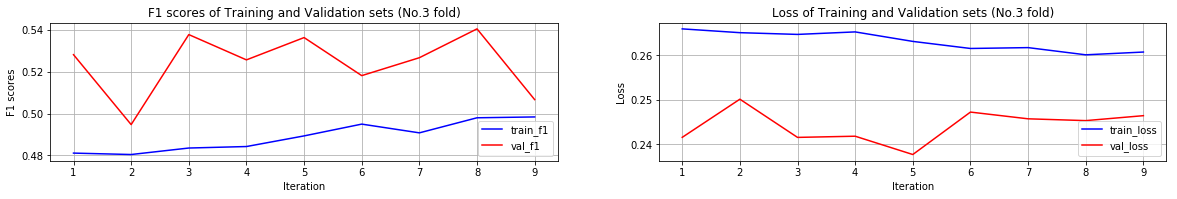

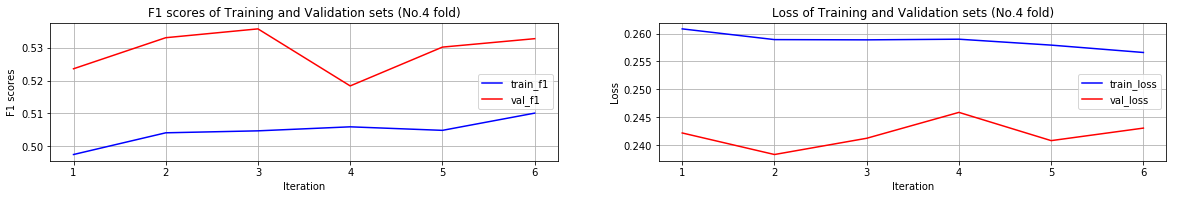

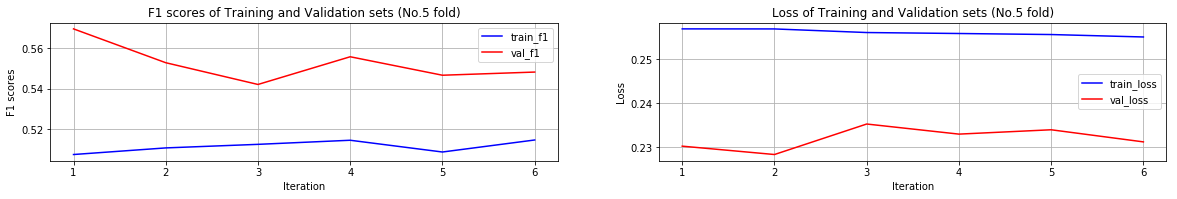

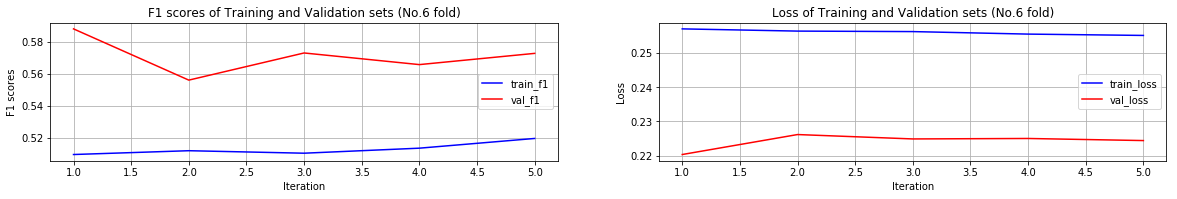

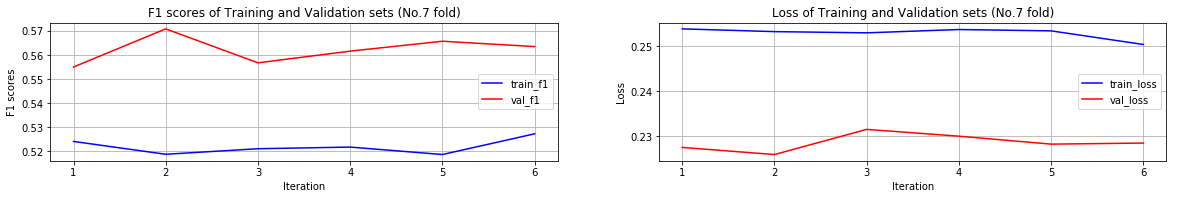

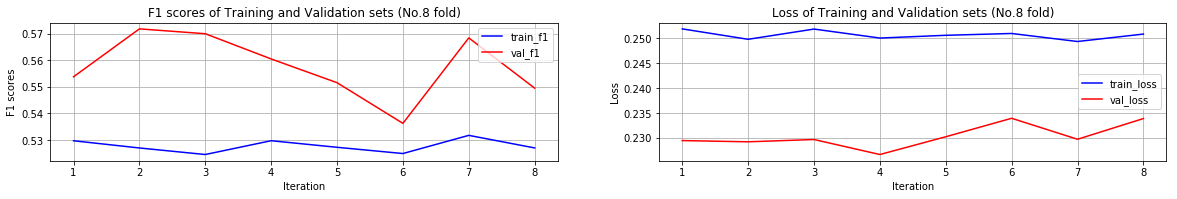

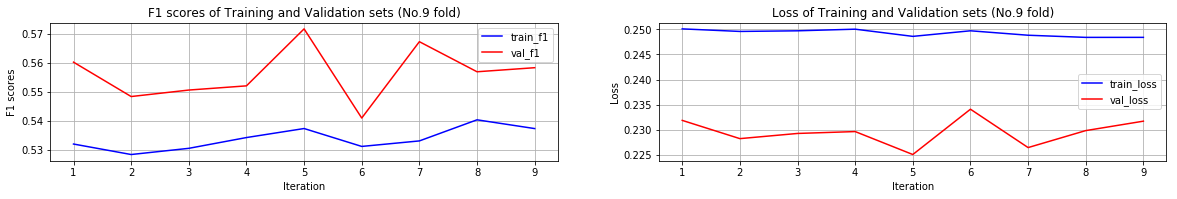

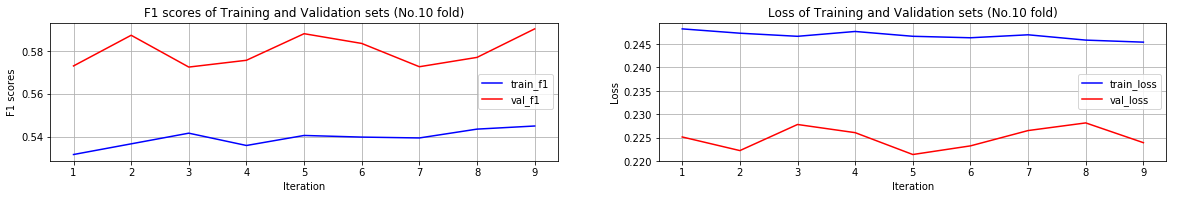

In [301]:
# there are 10 folds, so there are 10 groups of data
for i in range(0, len(cv_training_f1_score)):
    iteration = range(1,len(cv_training_f1_score[i])+1)
    plt.figure(figsize=(20,30))
    plt.subplot(10,2,1)
    plt.plot(iteration, cv_training_f1_score[i], linestyle='-', color='blue', label='train_f1')
    plt.plot(iteration, cv_val_f1_score[i], linestyle='-', color='red', label='val_f1')
    plt.grid()
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('F1 scores')
    plt.title('F1 scores of Training and Validation sets (No.%.0f fold)' % (i+1))
    
    plt.subplot(10,2,2)
    plt.plot(iteration, cv_training_loss[i], linestyle='-', color='blue', label='train_loss')
    plt.plot(iteration, cv_val_loss[i], linestyle='-', color='red', label='val_loss')
    plt.grid()
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss of Training and Validation sets (No.%.0f fold)' % (i+1))

From the above two groups performance of Xeception architecture and LeNet archtecture, we can see that both of these two models performs well in the testing data. Besides, it looks like the LeNet performs a little bit better and more stable than Xception network.

## Xception CNN

In [284]:
# speed up by training by not using augmentation, perhaps there are faster ways??
xception_model.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=[mcor,recall, f1])

x_history = xception_model.fit(X_train, y_train_ohe, batch_size=32,
            epochs=50, verbose=1,
            validation_data=(X_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
            )

Train on 28709 samples, validate on 7178 samples
Epoch 1/50
28709/28709 [==============================] - 15s 531us/step - loss: 1.1181 - mcor: 0.4956 - recall: 0.3887 - f1: 0.5119 - val_loss: 1.0949 - val_mcor: 0.5008 - val_recall: 0.3736 - val_f1: 0.5059
Epoch 2/50
28709/28709 [==============================] - 10s 337us/step - loss: 1.0888 - mcor: 0.5064 - recall: 0.4004 - f1: 0.5236 - val_loss: 1.0852 - val_mcor: 0.5079 - val_recall: 0.3879 - val_f1: 0.5176
Epoch 3/50
28709/28709 [==============================] - 10s 334us/step - loss: 1.0729 - mcor: 0.5176 - recall: 0.4122 - f1: 0.5353 - val_loss: 1.0900 - val_mcor: 0.5041 - val_recall: 0.3844 - val_f1: 0.5143
Epoch 4/50
28709/28709 [==============================] - 10s 353us/step - loss: 1.0518 - mcor: 0.5208 - recall: 0.4205 - f1: 0.5410 - val_loss: 1.0747 - val_mcor: 0.5123 - val_recall: 0.3991 - val_f1: 0.5261
Epoch 5/50
28709/28709 [==============================] - 10s 338us/step - loss: 1.0337 - mcor: 0.5283 - recall: 0.

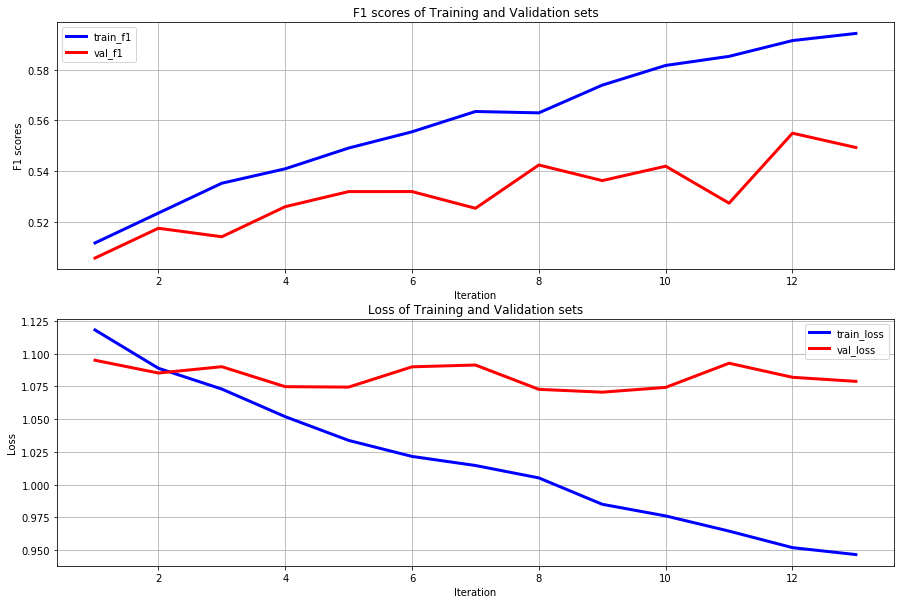

In [285]:
## visualize the performance of training and validation set of each iteration
from matplotlib import pyplot as plt

iteration = range(1,len(x_history.history.get('f1'))+1)

train_f1 = x_history.history.get('f1')
train_loss = x_history.history.get('loss')

val_f1 = x_history.history.get('val_f1')
val_loss = x_history.history.get('val_loss')

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(iteration, train_f1, linestyle='-', lw=3, color='blue', label='train_f1')
plt.plot(iteration, val_f1, linestyle='-', lw=3, color='red', label='val_f1')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('F1 scores')
plt.title('F1 scores of Training and Validation sets')

plt.subplot(2,1,2)
plt.plot(iteration, train_loss, lw=3, color='blue', label='train_loss')
plt.plot(iteration, val_loss, lw=3, color='red', label='val_loss')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss of Training and Validation sets')
plt.show()

### Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 

# Proper Statistics ????? How ???

#### Xception

In [286]:
# speed up by training by not using augmentation, perhaps there are faster ways??
xception_model.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=[mcor,recall, f1])

x_history = xception_model.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Epoch 1/50
224/224 [==============================] - 16s 70ms/step - loss: 1.1965 - mcor: 0.4606 - recall: 0.3461 - f1: 0.4725 - val_loss: 1.0839 - val_mcor: 0.5044 - val_recall: 0.3766 - val_f1: 0.5116
Epoch 2/50
224/224 [==============================] - 11s 49ms/step - loss: 1.1744 - mcor: 0.4700 - recall: 0.3514 - f1: 0.4800 - val_loss: 1.0892 - val_mcor: 0.5090 - val_recall: 0.3912 - val_f1: 0.5222
Epoch 3/50
224/224 [==============================] - 11s 49ms/step - loss: 1.1717 - mcor: 0.4679 - recall: 0.3502 - f1: 0.4786 - val_loss: 1.0904 - val_mcor: 0.5083 - val_recall: 0.3828 - val_f1: 0.5172
Epoch 4/50
224/224 [==============================] - 11s 49ms/step - loss: 1.1666 - mcor: 0.4725 - recall: 0.3554 - f1: 0.4838 - val_loss: 1.0755 - val_mcor: 0.5035 - val_recall: 0.3869 - val_f1: 0.5169
Epoch 5/50
224/224 [==============================] - 11s 49ms/step - loss: 1.1603 - mcor: 0.4764 - recall: 0.3584 - f1: 0.4875 - val_loss: 1.0753 - val_mcor: 0.5064 - val_recall: 0.38

#### LeNet

In [287]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=[mcor,recall, f1])

# the flow method yields batches of images indefinitely, with the given transofmrations
res_history = resnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Epoch 1/50
224/224 [==============================] - 16s 71ms/step - loss: 1.0679 - mcor: 0.5220 - recall: 0.4210 - f1: 0.5439 - val_loss: 1.0237 - val_mcor: 0.5445 - val_recall: 0.4508 - val_f1: 0.5699
Epoch 2/50
224/224 [==============================] - 11s 50ms/step - loss: 1.0648 - mcor: 0.5170 - recall: 0.4163 - f1: 0.5388 - val_loss: 1.0281 - val_mcor: 0.5387 - val_recall: 0.4412 - val_f1: 0.5623
Epoch 3/50
224/224 [==============================] - 11s 49ms/step - loss: 1.0579 - mcor: 0.5257 - recall: 0.4234 - f1: 0.5470 - val_loss: 1.0272 - val_mcor: 0.5334 - val_recall: 0.4262 - val_f1: 0.5526
Epoch 4/50
224/224 [==============================] - 11s 49ms/step - loss: 1.0599 - mcor: 0.5236 - recall: 0.4213 - f1: 0.5448 - val_loss: 1.0352 - val_mcor: 0.5326 - val_recall: 0.4436 - val_f1: 0.5602
Epoch 5/50
224/224 [==============================] - 11s 49ms/step - loss: 1.0620 - mcor: 0.5225 - recall: 0.4217 - f1: 0.5444 - val_loss: 1.0325 - val_mcor: 0.5344 - val_recall: 0.43

7178/7178 [==============================] - 1s 142us/step
Performance of Xception
loss : 1.0766185015880088
mcor : 0.5085657823879628
recall : 0.39370298133184733
f1 : 0.5213007134260591


7178/7178 [==============================] - 1s 131us/step
Performance of LeNet
loss : 1.032537790502669
mcor : 0.5332602272793655
recall : 0.43368626361638596
f1 : 0.5544678387485131


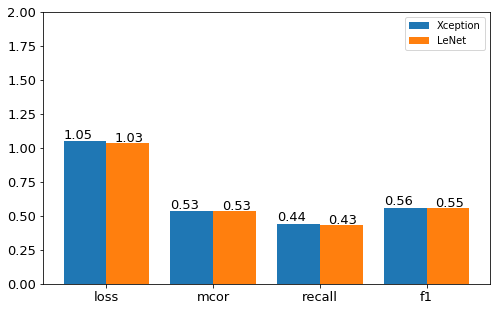

In [288]:
x_performance = xception_model.evaluate(X_test, y_test_ohe)

print('Performance of Xception')
for i in range(len(xception_model.metrics_names)):
    print(xception_model.metrics_names[i], ': '+str(x_performance[i]))

print('\n')

res_performance = resnet.evaluate(X_test, y_test_ohe)
print('Performance of LeNet')
for i in range(len(resnet.metrics_names)):
    print(resnet.metrics_names[i], ': '+str(res_performance[i]))

# Visualize the final results of the CNNs and interpret the performance. 
# Use proper statistics as appropriate, especially for comparing models.

mn = xception_model.metrics_names
width = 0.4
index = range(len(x_performance))
x1 = [i-0.2 for i in index]
x2 = [i+0.2 for i in index]
# change the figure size
plt.figure(figsize=(8,5))

# plot the bars
plt.bar(x1, xcep_performance, width=width, label='Xception')
plt.bar(x2, res_performance, width=width, label='LeNet')

# change the integer xlabels into text
plt.xticks(index, mn, fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,2.0)

# add data label on each of the bar
for a,b in zip(x1, xcep_performance):
    plt.text(a-0.2, b+0.02, np.round(b,2), fontsize=13)
for a,b in zip(x2, res_performance):
    plt.text(a-0.12, b+0.01, np.round(b,2), fontsize=13)

plt.legend()

# Exceptional work

[10 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

## Standard sklearn MLP

In [289]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

X_clf = df3['pixels'].values
y_clf = df3['emotion'].values

X_clf = np.concatenate(X_clf)
X_clf = X_clf.reshape((len(df3['pixels']),2304))

X_clf = X_clf/255.0 - 0.5

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, shuffle=True)

# these values have been hand tuned
clf = MLPClassifier(hidden_layer_sizes=(50,), 
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=200, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train_clf,y_train_clf)
yhat = clf.predict(X_test_clf)
print('F1 scores:',f1_score(yhat,y_test_clf,average='macro'))
print('Validation Acc:',accuracy_score(yhat,y_test_clf))


CPU times: user 53min 42s, sys: 3min 54s, total: 57min 37s
Wall time: 1min 43s
F1 scores: 0.3462267610829085
Validation Acc: 0.381861242685985


Epoch 1/1
28709/28709 [==============================] - 9s 309us/step - loss: 0.9993 - mcor: 0.5442 - recall: 0.4527 - f1: 0.5688
Epoch 1/1
28709/28709 [==============================] - 9s 311us/step - loss: 1.0867 - mcor: 0.5112 - recall: 0.4148 - f1: 0.5331


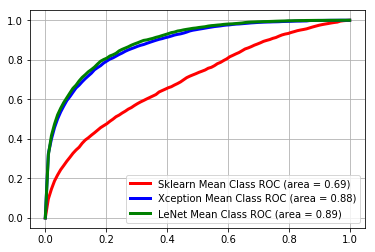

In [290]:
# Great! Its seems we are also maxing out the F1 score, lets go with C==1e-3
from sklearn.metrics import roc_curve, auc
from scipy import interp

########################### Sklearn ###############
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

probas = clf.fit(X_train_clf,
                y_train_clf).predict_proba(X_test_clf)

perclass_mean_tpr = 0.0
roc_auc = 0
classes = np.unique(y_train_clf)

# get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test_clf,
                                    probas[:, j],
                                    pos_label=j)
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)
        
perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr
plt.plot(mean_fpr,perclass_mean_tpr,'-',color='red', lw=3,label='Sklearn Mean Class ROC (area = %0.2f)'
                   % (roc_auc))


########################### Xception ###############
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

history = xception_model.fit(X_train,y_train_ohe)
probas = xception_model.predict(X_test)

perclass_mean_tpr = 0.0
roc_auc = 0
classes = np.unique(y_train)
# get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                    probas[:, j],
                                    pos_label=j)
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)
        
perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr

plt.plot(mean_fpr,perclass_mean_tpr,'-',color='blue', lw=3,label='Xception Mean Class ROC (area = %0.2f)'
                   % (roc_auc))

# plt.legend(loc='best')
# plt.grid()
# plt.show()

########################### LeNet ###############
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

history = resnet.fit(X_train,y_train_ohe)
probas = resnet.predict(X_test)

perclass_mean_tpr = 0.0
roc_auc = 0
classes = np.unique(y_train)
# get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                    probas[:, j],
                                    pos_label=j)
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)
        
perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr

plt.plot(mean_fpr,perclass_mean_tpr,'-',color='green', lw=3,label='LeNet Mean Class ROC (area = %0.2f)'
                   % (roc_auc))

plt.legend(loc='best')
plt.grid()
plt.show()

As what the ROC graph above shows, Xception/LeNet architecture has a larger area under the curve than sklearn, which also means it performs better and easier to disguish different label classes.

## Transfer learn

Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training from scratch in terms of classification performance. 

In [291]:
X = df3['pixels'].values
y = df3['emotion'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=20)
X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)

X_train = X_train/255.0 - 0.5
X_test = X_test/255.0 - 0.5

print(X_train.shape)
print(X_test.shape)

X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(X_train.shape)
print(X_test.shape)

(66145536,)
(16538112,)
(28709, 48, 48, 1)
(7178, 48, 48, 1)


In [292]:
# from skimage.transform import resize
# resize the data

from scipy.misc import imresize
from skimage.transform import resize
import numpy as np
import skimage

# convert the gray scale image to rgb (3 channels)

x_train_up = [skimage.color.gray2rgb(np.resize(x, (48,48))) 
              for x in X_train]
# x_train_up = [resize(x, output_shape=(48,48,3)) for x in X_train]
x_train_up = np.stack(x_train_up, axis=0)
print(x_train_up.shape)

x_test_up = [skimage.color.gray2rgb(np.resize(x, (48,48))) 
             for x in X_test]
x_test_up = np.stack(x_test_up, axis=0)
print(x_test_up.shape)


(28709, 48, 48, 3)
(7178, 48, 48, 3)


In [293]:
## for test
# x1 = x_train_up[0].copy()

# x1 = np.expand_dims(x1, axis=0)
# x1 = preprocess_input(x1)
# print(x1.shape)
# plt.imshow(x1[0])

In [294]:
# connect new layers to the output
from keras.applications.xception import xception
from keras.applications.xception import preprocess_input, decode_predictions

# load only convolutional layers of resnet:
xception_no_top = xception.Xception(weights='imagenet', include_top=False)
# xception_no_top.summary()

## performance on scratch
x = x_train_up[0].copy()
# x = resize(x, output_shape=(48,48,3))
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
%time preds = xception_no_top.predict(x)
preds.shape

CPU times: user 2.62 s, sys: 1.11 ms, total: 2.62 s
Wall time: 2.62 s


(1, 2, 2, 2048)

In [295]:
# pre-process the input data
x_train_up = preprocess_input(x_train_up)
x_test_up = preprocess_input(x_test_up)

In [296]:
%%time

# train on half the data, to save a few hours
x_train_xception = xception_no_top.predict(x_train_up)
x_test_xception = xception_no_top.predict(x_test_up)
print(x_train_xception.shape)

(28709, 2, 2, 2048)
CPU times: user 22 s, sys: 2.24 s, total: 24.2 s
Wall time: 16.3 s


In [297]:
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras.models import Input, Model


# let's add a fully-connected layer
input_x = Input(shape=x_train_xception[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 200)               1638600   
_________________________________________________________________
dense_30 (Dense)             (None, 7)                 1407      
Total params: 1,640,007
Trainable params: 1,640,007
Non-trainable params: 0
_________________________________________________________________


In [298]:
# fit the data with pre-trained model

y_train_ohe_xception = y_train_ohe[:x_train_xception.shape[0]]

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=[mcor,recall, f1])

tl_history = model.fit(x_train_xception,y_train_ohe_xception,
                epochs=20,
                batch_size=64,
                verbose=1,
                validation_data=(x_test_xception, y_test_ohe[:x_test_xception.shape[0]]),
                callbacks = [EarlyStopping(monitor='val_loss', patience=4)])

Train on 28709 samples, validate on 7178 samples
Epoch 1/20
28709/28709 [==============================] - 8s 295us/step - loss: 1.7927 - mcor: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 1.7669 - val_mcor: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/20
28709/28709 [==============================] - 3s 104us/step - loss: 1.7551 - mcor: 0.0028 - recall: 5.2248e-04 - f1: 0.0010 - val_loss: 1.7492 - val_mcor: -3.4433e-04 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/20
28709/28709 [==============================] - 3s 100us/step - loss: 1.7351 - mcor: 0.0183 - recall: 0.0034 - f1: 0.0067 - val_loss: 1.7364 - val_mcor: 0.0567 - val_recall: 0.0123 - val_f1: 0.0237
Epoch 4/20
28709/28709 [==============================] - 3s 106us/step - loss: 1.7201 - mcor: 0.0306 - recall: 0.0064 - f1: 0.0123 - val_loss: 1.7476 - val_mcor: 0.0840 - val_recall: 0.0230 - val_f1: 0.0437
Epoch 5/20
28709/28709 [==============================] - 3s 104us/step - loss

In [299]:
# get the performance of 3 models by evaluating with test data
tl_performance = model.evaluate(x_test_xception, y_test_ohe[:x_test_xception.shape[0]])
xcep_performance = xception_model.evaluate(X_test, y_test_ohe)
lenet_performance = resnet.evaluate(X_test, y_test_ohe)

7178/7178 [==============================] - 1s 147us/step


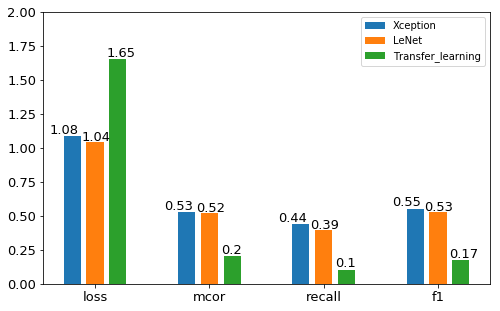

In [300]:
# visualize and compare the performance 

mn = model.metrics_names
width = 0.15
index = range(len(xcep_performance))
x1 = [i-0.2 for i in index]
x2 = [i for i in index]
x3 = [i+0.2 for i in index]
# change the figure size
plt.figure(figsize=(8,5))

# plot the bars
plt.bar(x1, xcep_performance, width=width, label='Xception')
plt.bar(x2, lenet_performance, width=width, label='LeNet')
plt.bar(x3, tl_performance, width=width, label='Transfer_learning')

# change the integer xlabels into text
plt.xticks(index, mn, fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,2.0)

# add data label on each of the bar
for a,b in zip(x1, xcep_performance):
    plt.text(a-0.2, b+0.02, np.round(b,2), fontsize=13)
for a,b in zip(x2, lenet_performance):
    plt.text(a-0.12, b+0.01, np.round(b,2), fontsize=13)
for a,b in zip(x3, tl_performance):
    plt.text(a-0.1, b+0.02, np.round(b,2), fontsize=13)
plt.legend()

As we can see above, the pre-trained Xceoption model has a terrible performance on our dataset, which has only 0.1 f1_socres and a very high 1.6 loss. We think one of the reason of the bad performance of this pre-trained model is that our dataset is originally gray scale images which have only one channel. However, the 'ImageNet' that is used to pre-train the model has 3 channels in each image of it. The image size of our dataset 48x48 pixels in 1 channel (48,48,1), but there was a error when we tried to fit them into the model which is 'the input_6 layer requires to be (None, None, 3)'. In order to meet the requirement, we 'had to' convert the gray scale image into RGB style. As a result, the performance drops dramatically.